In [1]:
import numpy as np
import pandas as pd

#misc
import time
import warnings
import os


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 
import scipy.stats

# graph viz
import plotly.offline as pyo
from plotly.graph_objs import *

#map section
import cartopy.crs as ccrs
import cartopy.feature as cfeature


#graph section
import networkx as nx
import heapq  # for getting top n number of things from list,dict


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")
pyo.init_notebook_mode()

%matplotlib inline
import json


### **Importing the Dataset**

In [2]:
checkin = pd.read_csv("yelp_checkin.csv")
business = pd.read_csv("yelp_business.csv")
review = pd.read_csv("yelp_review.csv")

### **Pre processing and Data Cleaning**

In [22]:
print("Business Dataset\n")
print(business.isnull().sum(),'\n')
print("Checkin Dataset\n")
print(checkin.isnull().sum(),'\n')
print("Review Dataset\n")
print(review.isnull().sum(),'\n')

Business Dataset

business_id         0
name                0
neighborhood    38059
address             0
city                0
state               0
postal_code       199
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
categories          0
dtype: int64 

Checkin Dataset

business_id    0
weekday        0
hour           0
checkins       0
dtype: int64 

Review Dataset

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64 



### **Filter Dataset for Restaurants and Split dataset into Opened and Closed Restaurants**

In [3]:
business = business[business.categories.str.contains('Restaurants|Food|Cafe|Baker')]
open_check = pd.merge(business[['business_id','is_open','latitude','longitude','city','state','stars','review_count']],checkin,on='business_id')

In [4]:
closed_business = open_check[open_check.is_open == 0]
opened_business = open_check[open_check.is_open == 1]

### **Exploratory Data Analysis**

## Correlation between attributes in the datasets

In [24]:
print("Business Dataset Correlation\n")
print(business.corr(),'\n')
print("Checkin Dataset Correlation\n")
print(checkin.corr(),'\n')
print("Review Dataset Correlation\n")
print(review.corr(),'\n')

Business Dataset Correlation

              latitude  longitude     stars  review_count   is_open
latitude      1.000000   0.810764  0.072238     -0.166252  0.059995
longitude     0.810764   1.000000  0.090009     -0.178655  0.072589
stars         0.072238   0.090009  1.000000      0.100711  0.024591
review_count -0.166252  -0.178655  0.100711      1.000000  0.092644
is_open       0.059995   0.072589  0.024591      0.092644  1.000000 

Checkin Dataset Correlation

          checkins
checkins       1.0 

Review Dataset Correlation

           stars    useful     funny      cool
stars   1.000000 -0.077122 -0.048866  0.044828
useful -0.077122  1.000000  0.621663  0.677069
funny  -0.048866  0.621663  1.000000  0.661669
cool    0.044828  0.677069  0.661669  1.000000 



Text(0.5, 1.0, 'Review')

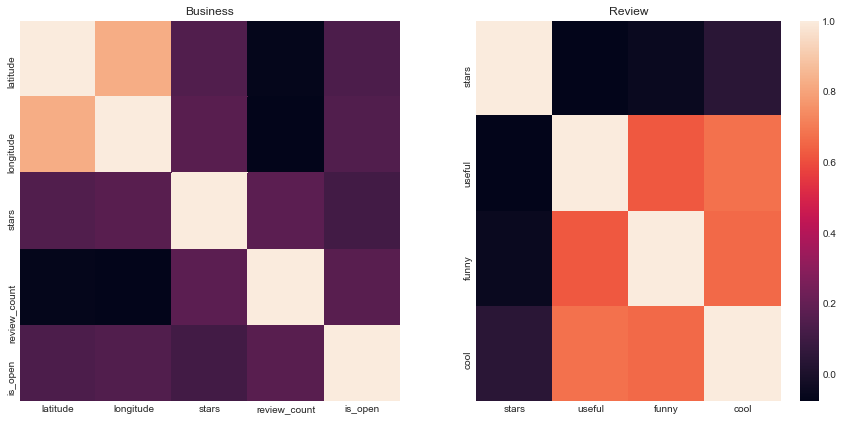

In [29]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
sns.heatmap(business.corr(),cbar=False,ax=ax1)
ax1.set_title('Business')
sns.heatmap(review.corr(),ax=ax2)
ax2.set_title('Review')

## Box Plot

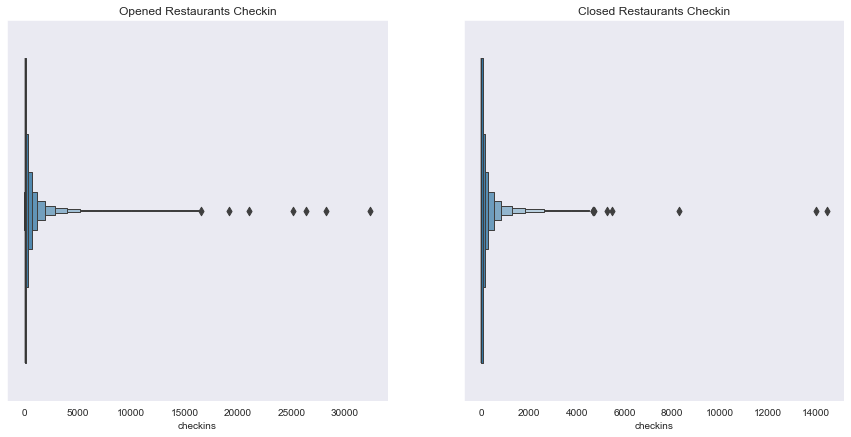

In [5]:
# Box plot of the number of checkins of restaurants

fig,axes= plt.subplots(1,2,figsize=(15,7))
sns.boxenplot(opened_business.groupby('business_id').sum().checkins,ax=axes[0])
axes[0].set_title('Opened Restaurants Checkin')

sns.boxenplot(closed_business.groupby('business_id').sum().checkins,ax=axes[1])
axes[1].set_title('Closed Restaurants Checkin')

plt.show()

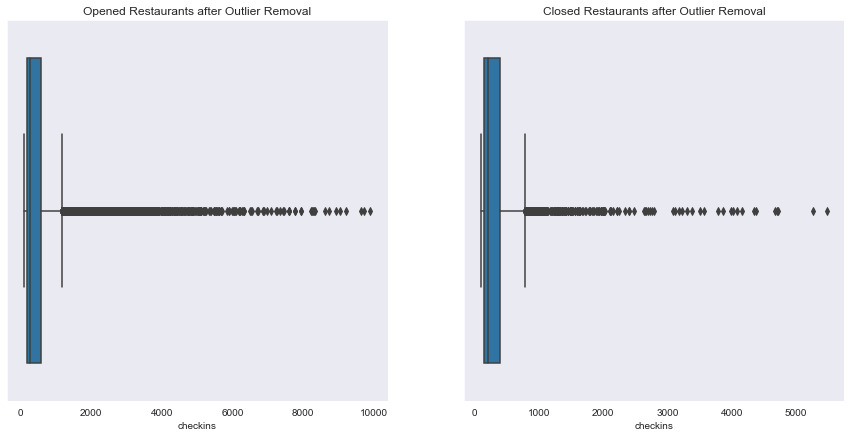

In [6]:
#Box plot of the number of checkins of restaurants after removal of outliers

fig,axes= plt.subplots(1,2,figsize=(15,7))

opens = opened_business.groupby('business_id').sum()
opens = opens[(opens.checkins > 100) & (opens.checkins < 10000)].dropna()
cs = closed_business.groupby('business_id').sum()
cs = cs[(cs.checkins > 100) & (cs.checkins < 6000)].dropna()

sns.boxplot(opens.checkins,ax=axes[0])
axes[0].set_title('Opened Restaurants after Outlier Removal')
sns.boxplot(cs.checkins,ax=axes[1])
axes[1].set_title('Closed Restaurants after Outlier Removal')

plt.show()


## Distribution of Star Rating

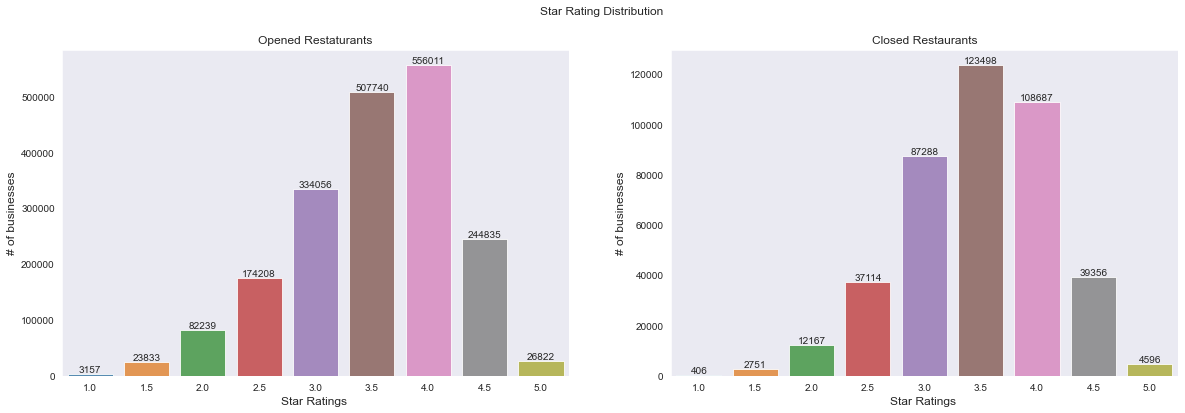

In [7]:
#Get the distribution of the ratings

#Opened restaurants
x=opened_business['stars'].value_counts()
x=x.sort_index()

#plot
fig,axes = plt.subplots(1,2,figsize=(20,6))
sns.barplot(x.index, x.values, alpha=0.8,ax=axes[0])
fig.suptitle("Star Rating Distribution")
axes[0].set_title('Opened Restaturants')
axes[0].set_ylabel('# of businesses', fontsize=12)
axes[0].set_xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = axes[0].patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

#Closed Restaurants
x=closed_business['stars'].value_counts()
x=x.sort_index()

#plot
sns.barplot(x.index, x.values, alpha=0.8,ax=axes[1])
axes[1].set_title("Closed Restaurants")
axes[1].set_ylabel('# of businesses', fontsize=12)
axes[1].set_xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = axes[1].patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes[1].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()



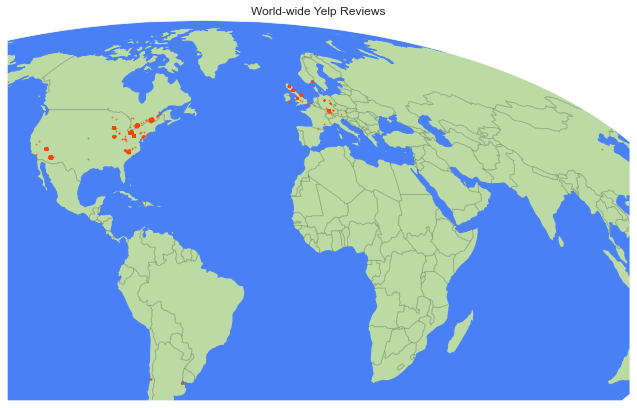

In [8]:
#basic cartopy of the world
# use orthographic projection for the globe type version

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude=-50))

# hex codes from google maps color pallete = http://www.color-hex.com/color-palette/9261

#add continents
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='#bbdaa4')

# add the oceans
ax.add_feature(cfeature.OCEAN, zorder=0, color='#4a80f5')
               
# Draw the boundaries of the countires
ax.add_feature(cfeature.BORDERS, zorder=0,alpha=0.2)

#Add the scatter points to indicate the locations of the businesses
plt.scatter(x=business["longitude"].tolist(), y=business["latitude"].tolist(),
            color="orangered",
            s=1,
            alpha=0.5,
            transform=ccrs.PlateCarree()) ## Important

plt.title("World-wide Yelp Reviews")
plt.show()

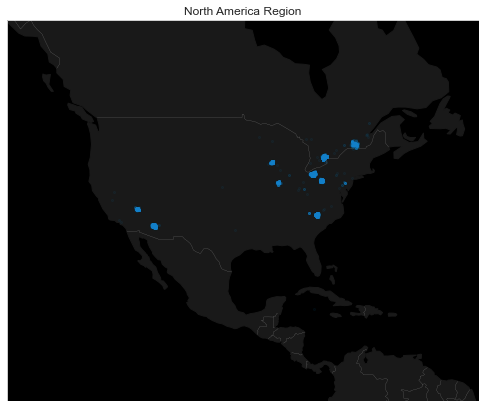

In [9]:
# Sample it down to only the North America region 
lon_min, lon_max = -140, -50
lat_min, lat_max = 2,50.5

#create the selector
idx_NA = (business["longitude"]>lon_min) &\
            (business["longitude"]<lon_max) &\
            (business["latitude"]>lat_min) &\
            (business["latitude"]<lat_max)
            
# apply the selector to subset
NA_business=business[idx_NA]

# plot
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-140, -50, 2, 50.5])

# adding the Lakes, Continent and Borders
ax.add_feature(cfeature.LAKES, zorder=0, color='#000000')
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='#191919')
ax.add_feature(cfeature.BORDERS, color='w',linewidth=0.1)
ax.set_facecolor('#000000')

#Add the scatter points to indicate the locations of the businesses
plt.scatter(x=NA_business["longitude"].tolist(), y=NA_business["latitude"].tolist(),
            color="#1292db",
            s=5,
            alpha=0.05,
            zorder=5,
            transform=ccrs.PlateCarree())


plt.title("North America Region")
plt.show()

## City View

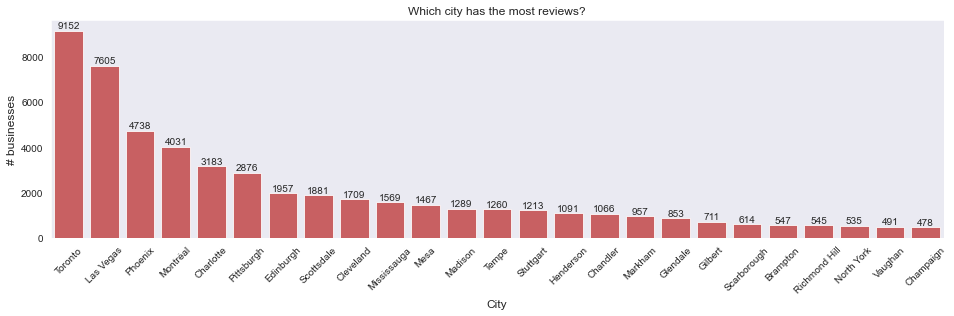

In [10]:
#Cities with the most number of reviews for restaurants

x=business['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:25]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[3])
plt.title("Which city has the most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [11]:
#get all ratings data for opened restaurants
rating_data_open = opened_business[['latitude','longitude','stars','review_count','hour', 'weekday', 'checkins']]
# Creating a custom column popularity using stars * no_of_reviews
rating_data_open['popularity'] = rating_data_open['stars'] * rating_data_open['review_count']

#get all ratings data for closed restaurants
rating_data_closed = closed_business[['latitude','longitude','stars','review_count','hour', 'weekday', 'checkins']]
# Creating a custom column popularity using stars * no_of_reviews
rating_data_closed['popularity'] = rating_data_closed['stars'] * rating_data_closed['review_count']


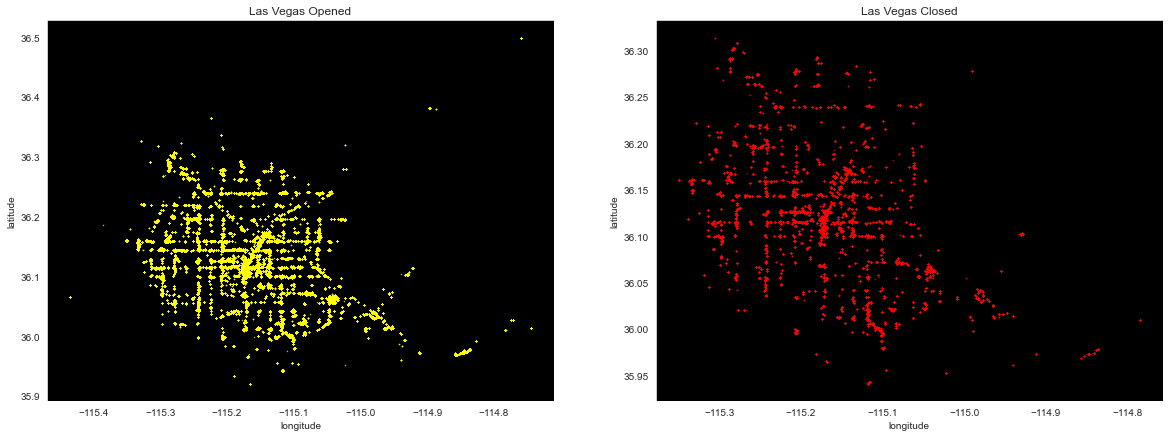

In [12]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

#a random point inside Las Vegas
lat = 36.1699
lon = -115.1398

#some adjustments to get the right area of Las vegas
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5

#Subset for Las Vegas
ratings_data_vegas_c=rating_data_closed[(rating_data_closed["longitude"]>lon_min) &\
                    (rating_data_closed["longitude"]<lon_max) &\
                    (rating_data_closed["latitude"]>lat_min) &\
                    (rating_data_closed["latitude"]<lat_max)]

ratings_data_vegas_o=rating_data_open[(rating_data_open["longitude"]>lon_min) &\
                    (rating_data_open["longitude"]<lon_max) &\
                    (rating_data_open["latitude"]>lat_min) &\
                    (rating_data_open["latitude"]<lat_max)]

#plot Las Vegas

ratings_data_vegas_c.plot(kind='scatter', x='longitude', y='latitude',
                color='red', 
                s=.2, alpha=.9, subplots=True, ax=ax2)

ratings_data_vegas_o.plot(kind='scatter', x='longitude', y='latitude',
                color='yellow', 
                s=.2, alpha=.9, subplots=True, ax=ax1)

ax2.set_title("Las Vegas Closed")
ax1.set_title("Las Vegas Opened")
ax2.set_facecolor('black')
ax1.set_facecolor('black')
f.show()

## Box plot for Las Vegas city

In [13]:
closed = closed_business[(closed_business["longitude"]>lon_min) &\
                    (closed_business["longitude"]<lon_max) &\
                    (closed_business["latitude"]>lat_min) &\
                    (closed_business["latitude"]<lat_max)]
opened = opened_business[(opened_business["longitude"]>lon_min) &\
                    (opened_business["longitude"]<lon_max) &\
                    (opened_business["latitude"]>lat_min) &\
                    (opened_business["latitude"]<lat_max)]

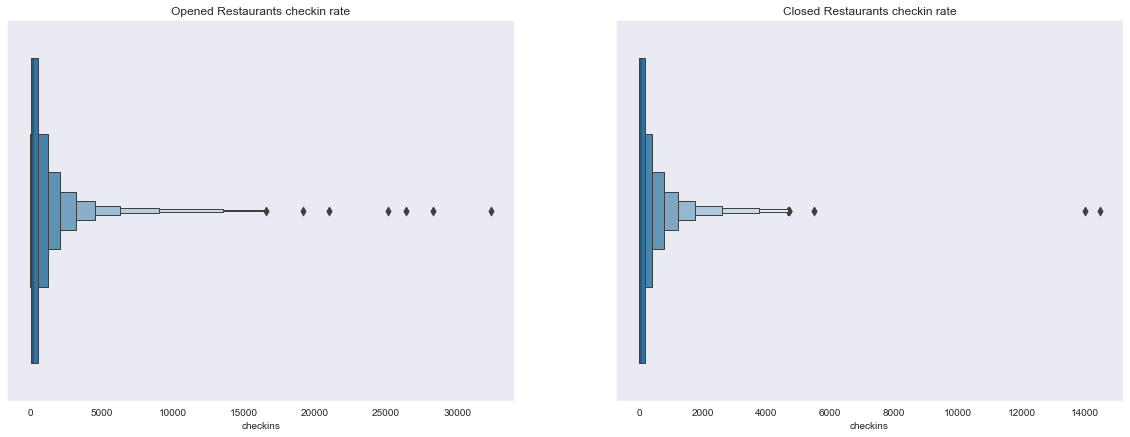

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

sns.boxenplot(opened.groupby('business_id').sum().checkins,ax=ax1)
ax1.set_title('Opened Restaurants checkin rate')
sns.boxenplot(closed.groupby('business_id').sum().checkins,ax=ax2)
ax2.set_title('Closed Restaurants checkin rate')

plt.show()


In [15]:
#Function which highlights the max of a column

def highlight_max(x, color):
    return np.where(x == np.nanmax(x.to_numpy()), f"color: {color};", None)

In [16]:
#Grouping the checkins of opened restaurants on the basis of weekday and hour 
RVO = ratings_data_vegas_o.groupby(['weekday','hour'])['checkins'].sum()
RVO = RVO.reset_index()
RVO = RVO.pivot(index='hour',columns='weekday')[['checkins']]
RVO.columns = RVO.columns.droplevel()
RVO = RVO.reset_index()

# Workaround for not being able to sort the values by hour
RVO.hour = RVO.hour.apply(lambda x: str(x).split(':')[0])
RVO.hour = RVO.hour.astype(int)

# Sort the hour column 
RVO = RVO.sort_values('hour')
RVO = RVO[['hour','Mon', 'Tue','Wed','Thu','Fri','Sat', 'Sun' ]]

#highlight the max of each column
RVO.style.apply(highlight_max, color='darkorange', axis=0)

In [17]:
#Grouping the checkins of closed restaurants on the basis of weekday and hour 
RVC=ratings_data_vegas_c.groupby(['weekday','hour'])['checkins'].sum()
RVC=RVC.reset_index()
RVC=RVC.pivot(index='hour',columns='weekday')[['checkins']]
RVC.columns = RVC.columns.droplevel()
RVC=RVC.reset_index()

# Workaround for not being able to sort the values by hour
RVC.hour=RVC.hour.apply(lambda x: str(x).split(':')[0])
RVC.hour=RVC.hour.astype(int)

# Sort the hour column 
RVC=RVC.sort_values('hour')
RVC=RVC[['hour','Mon', 'Tue','Wed','Thu','Fri','Sat', 'Sun' ]]

#highlight the max of each column
RVC.style.apply(highlight_max, color='darkorange', axis=0)

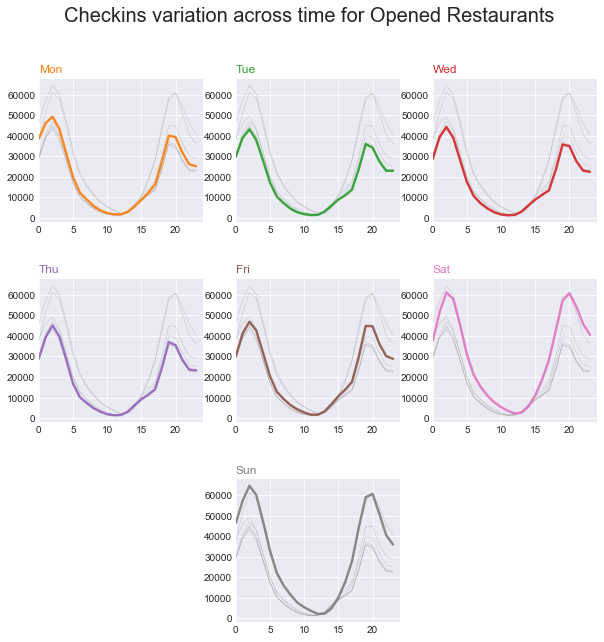

In [18]:
# Initialize the figure
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(10,10))
plt.suptitle("Checkins variation across time for Opened Restaurants",fontsize=20)
gridspec.GridSpec(3,3)
plt.subplots_adjust(hspace=0.4)

# multiple line plot for the opened restaurants per day
num=0
for column in RVO.drop('hour', axis=1):
    num+=1
    # Find the right spot on the plot
    
    if num==7:  # adjustment to fit sunday
        plt.subplot2grid((3,3),(2,1))
    else:
        plt.subplot(3,3, num)
    
    # plot every groups, but discreet
    for v in RVO.drop('hour', axis=1):
        plt.plot(RVO['hour'], RVO[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
    
    # Plot the lineplot
    plt.plot(RVO['hour'], RVO[column], marker='', color=color[num], linewidth=2.4, alpha=0.9, label=column)
    
    # Same limits for everybody!
    plt.xlim(0,24)

    # Not ticks everywhere
    if num in range(4) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
    
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0,color=color[num])


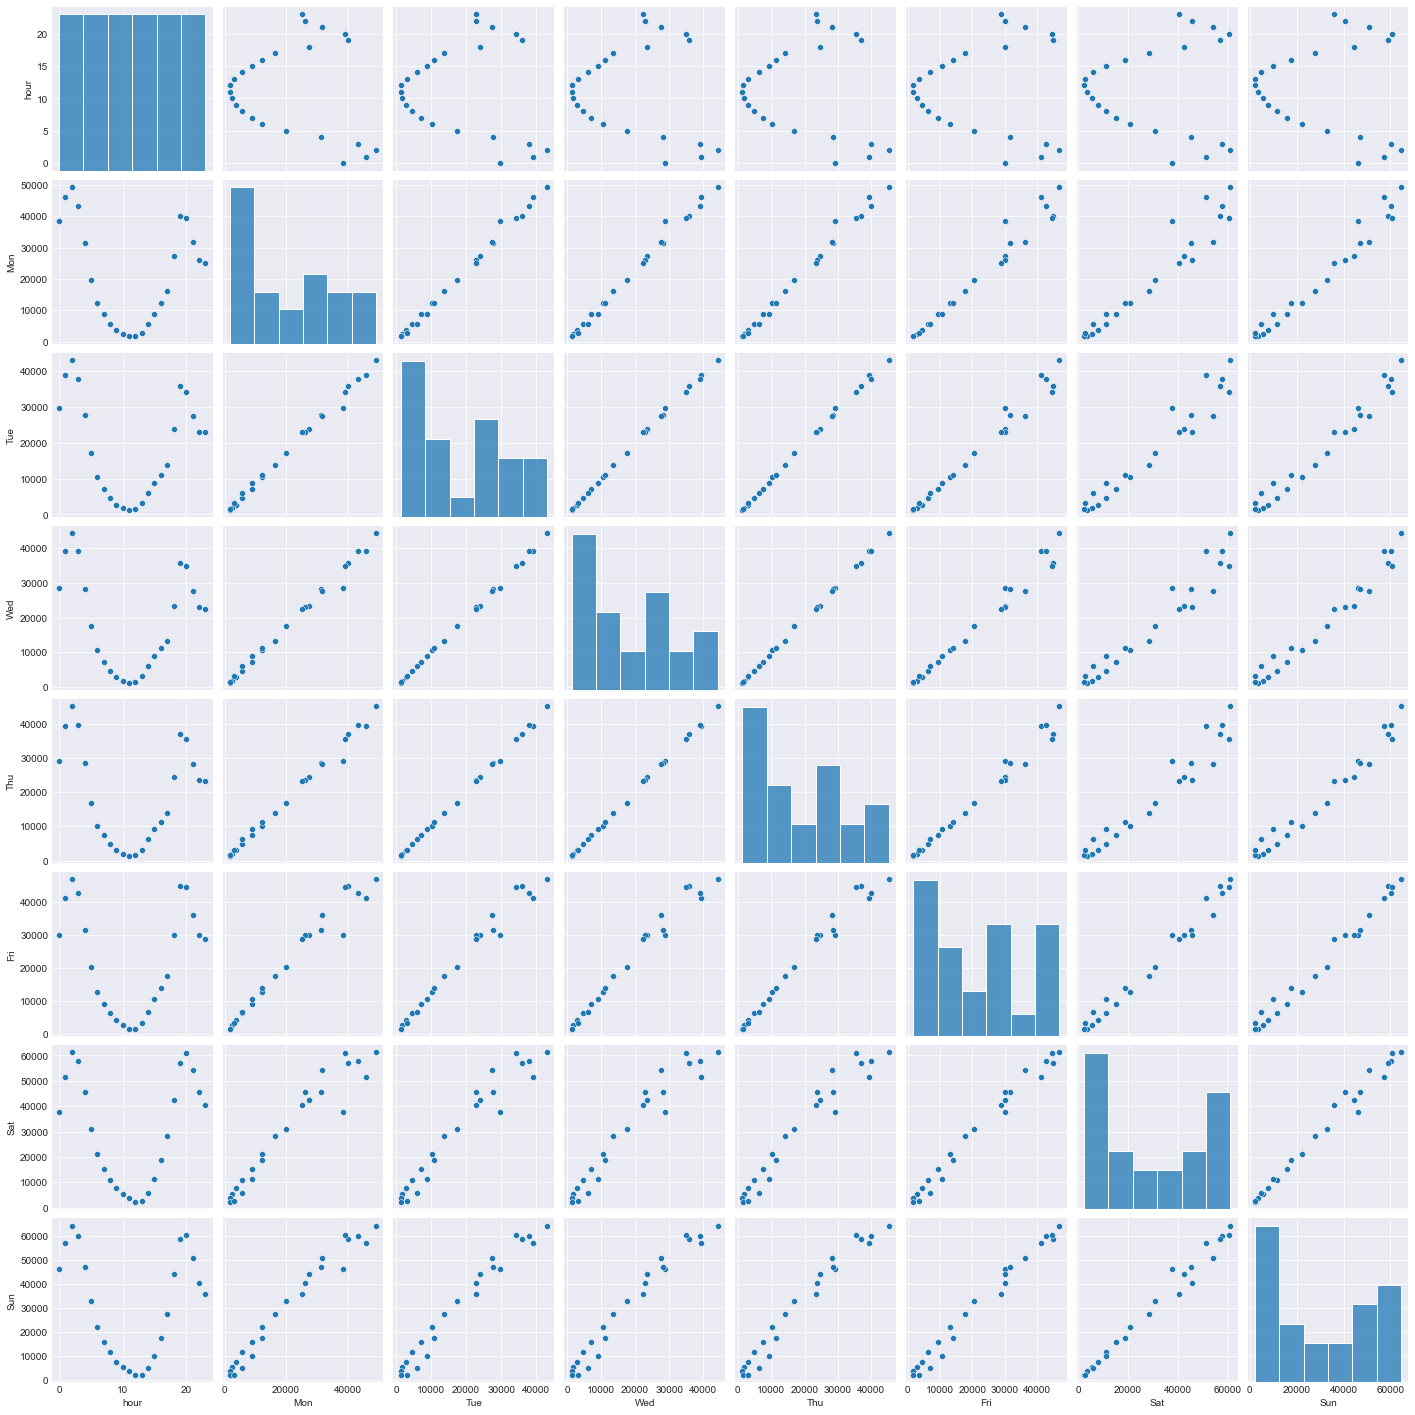

In [19]:
# A pair-plot of the checkins with respective to all the days for the opened restaurants

sns.pairplot(RVO)

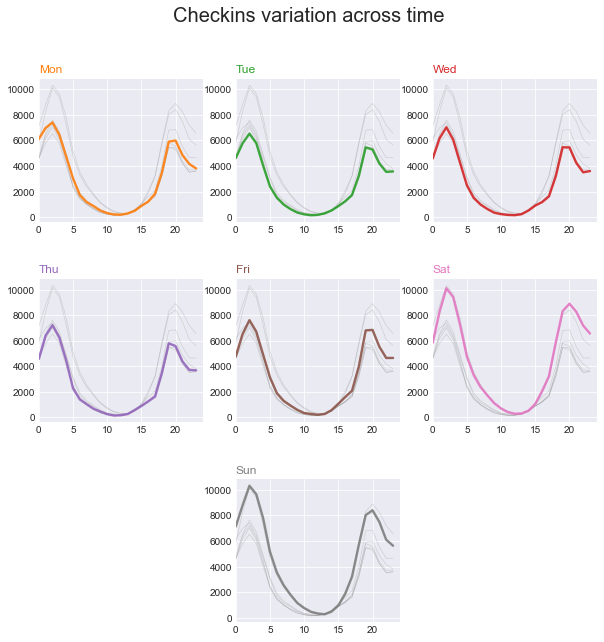

In [20]:

# Initialize the figure
plt.style.use('seaborn-darkgrid')
# create a color palette
palette = plt.get_cmap('Set1')
plt.figure(figsize=(10,10))
plt.suptitle("Checkins variation across time",fontsize=20)
gridspec.GridSpec(3,3)
plt.subplots_adjust(hspace=0.4)

# multiple line plot for the closed restaurants per day
num=0
for column in RVC.drop('hour', axis=1):
    num+=1
    # Find the right spot on the plot
    
    if num==7:  # adjustment to fit sunday
        plt.subplot2grid((3,3),(2,1))
    else:
        plt.subplot(3,3, num)
    
    # plot every groups, but discreet
    for v in RVC.drop('hour', axis=1):
        plt.plot(RVC['hour'], RVC[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
    # Plot the lineplot
    plt.plot(RVC['hour'], RVC[column], marker='', color=color[num], linewidth=2.4, alpha=0.9, label=column)
    # Same limits for everybody!
    plt.xlim(0,24)
    # plt.ylim(-2,260000)
    # Not ticks everywhere
    if num in range(4) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=color[num])

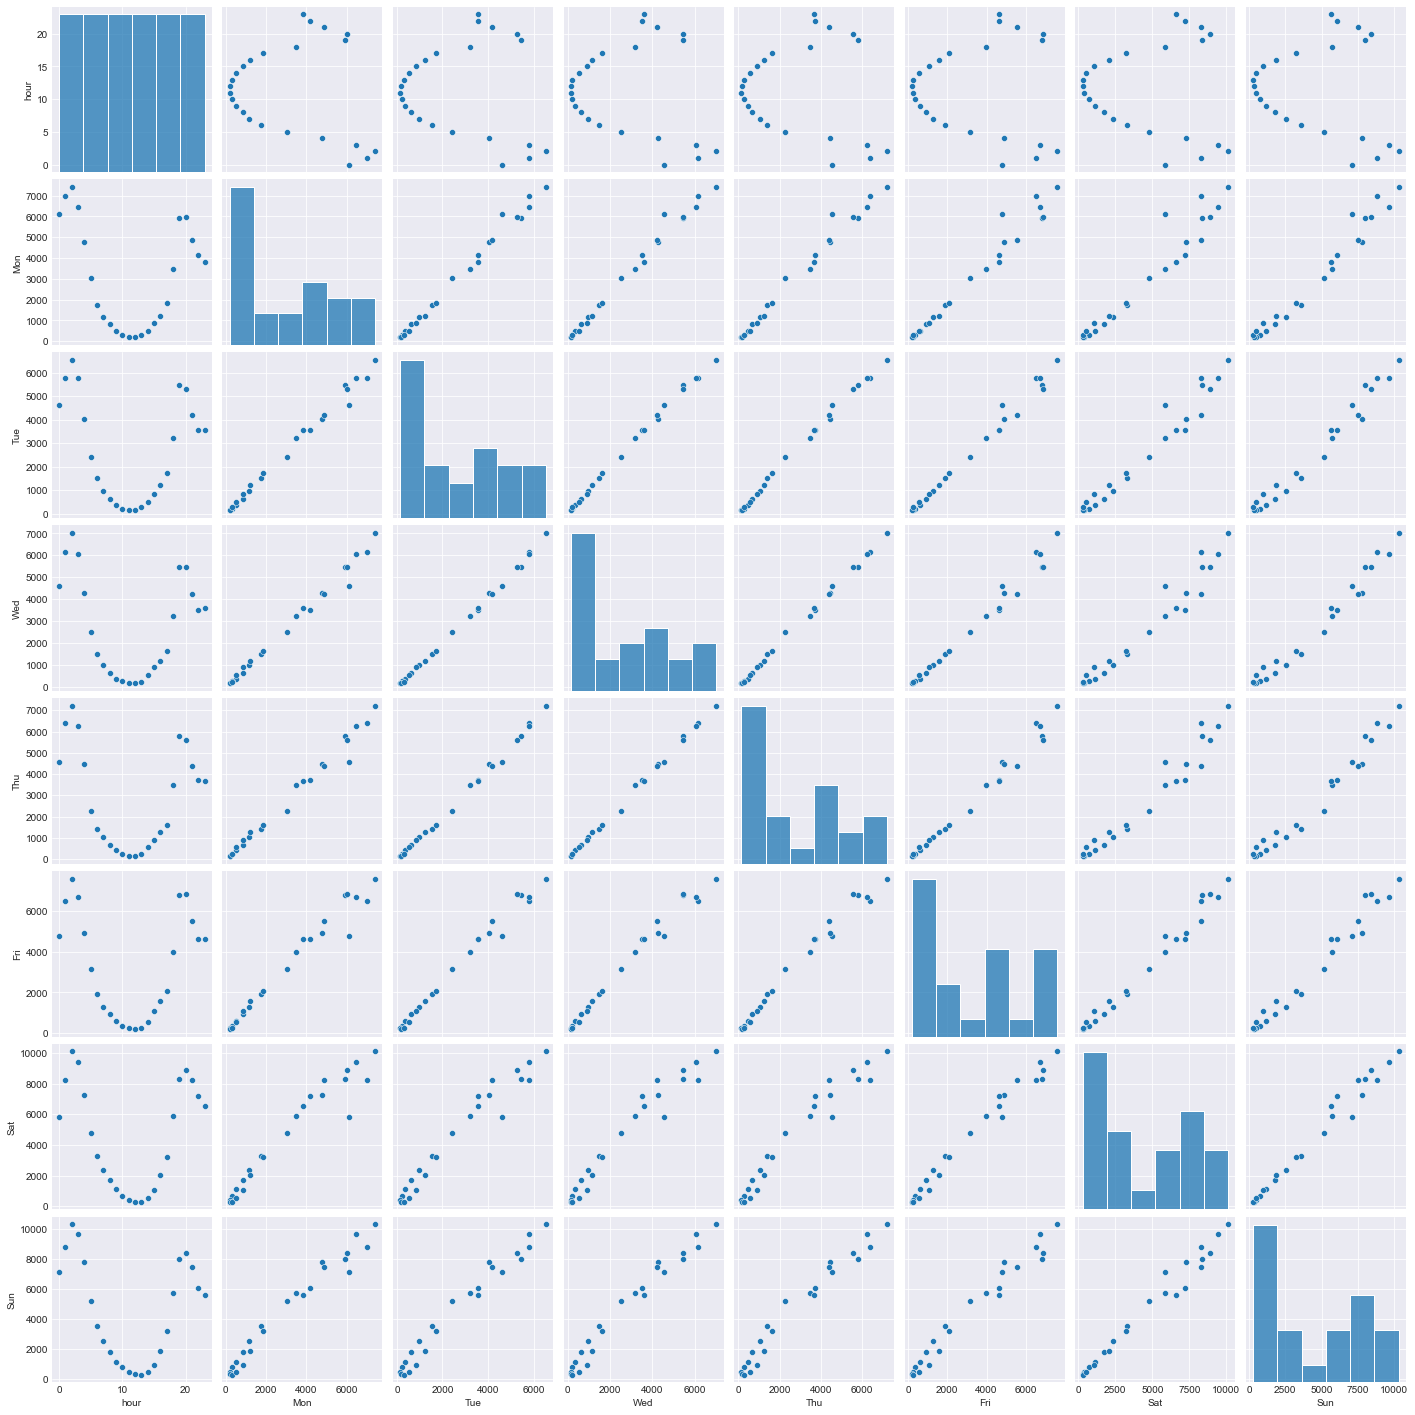

In [21]:
# A pair-plot of the checkins with respective to all the days for the closed restaurants

sns.pairplot(RVC)